In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import PIL

In [2]:
data=pd.read_csv("MLPerf0.7 - jsc.csv")

In [3]:
def _convert_floatstr(x):
    if x=="#DIV/0!":
        return np.nan
    else:
        return float(x)
    

In [4]:
data["Throughput"]=data["Throughput"].apply(_convert_floatstr)
#data["nodes"]=data["nodes"].apply(lambda x: np.nan if np.isnan(x) else int(x))

In [5]:
data=data.set_index(["Manufacturer", "Task","accelerators"])

In [6]:
data

nodes  \
Manufacturer Task                                               accelerators          
nvidia       resnet                                             8.0             1.0   
                                                                16.0            2.0   
                                                                768.0          96.0   
                                                                1536.0        192.0   
                                                                1840.0        230.0   
jsc          resnet                                             8.0             2.0   
                                                                16.0            4.0   
                                                                768.0         192.0   
                                                                1536.0        384.0   
                                                                1840.0        460.0   
nvidia       ssd                                                8.0             1.0   
                                                                16.0            2.0   
                                                                64.0            8.0   
                                                                512.0          64.0   
                                                                1024.0        128.0   
jsc          ssd                                                8.0             2.0   
                                                                16.0            4.0   
                                                                NaN             NaN   
                                                                NaN             NaN   
                                                                NaN             NaN   
nvidia       transformer                                        8.0             1.0   
                                                                16.0            2.0   
                                                                80.0           10.0   
                                                                160.0          20.0   
                                                                480.0          60.0   
jsc          transformer                                        8.0             2.0   
                                                                16.0            4.0   
                                                                80.0           20.0   
                                                                160.0          40.0   
                                                                480.0         120.0   
nvidia       bert                                               8.0             1.0   
                                                                16.0            2.0   
                                                                256.0          32.0   
                                                                1024.0        128.0   
                                                                2048.0        256.0   
jsc          bert                                               8.0             2.0   
                                                                16.0            4.0   
                                                                256.0          64.0   
                                                                1024.0        256.0   
                                                                2048.0        512.0   
nvidia       gnmt                                               8.0             1.0   
                                                                16.0            2.0   
                                                                256.0          32.0   
                                                                1024.0        128.0   
jsc          gnmt                                               8.0         

In [7]:
data.loc["nvidia", "resnet", 8].iloc[0]

<ipython-input-7-60ddb530e1ae>:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  data.loc["nvidia", "resnet", 8].iloc[0]


nodes                   1.0
runtime_minues        39.78
epochs                 42.0
time_per_epoch        56.83
train_samples     1281167.0
batch_size              NaN
Throughput          22500.0
Throughput/GPU     2.82E+03
Framework             mxnet
Comment                 NaN
Unnamed: 13             NaN
Name: (nvidia, resnet, 8.0), dtype: object

In [8]:
output=[
    ["resnet", 8],
    ["resnet", 16],
    ["resnet", 768],
    ["resnet", 1536],
    ["ssd", 8],
    ["ssd", 16],
    ["transformer", 8],
    ["transformer", 16],
    ["transformer", 80],
    ["transformer", 160],
    ["bert", 8],
    ["bert", 16],
    ["bert", 256],
    ["gnmt", 8],
    ["gnmt", 16],
    ["gnmt", 256]
]

In [9]:
def format_output(x):
    return x[0]+ " n: " + str(x[1])
labels=[ format_output(x) for x in output ]

In [10]:
def get_field(k, f):
    try:
        return data.loc[k[0], k[1], k[2]].iloc[0][f]
    except KeyError:
        return np.nan

In [11]:
keys_jsc=[  ["jsc"] + x   for x in output]
keys_nv=[  ["nvidia"] + x   for x in output]
data_jsc=[ get_field(k, "Throughput") for k in keys_jsc ]
data_nv=[ get_field(k, "Throughput") for k in keys_nv ]
data_nv_ideal=[ k[2]*get_field([ k[0], k[1], 8 ], "Throughput")/8 for k in keys_nv ]

<ipython-input-10-b5254fd93e5f>:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  return data.loc[k[0], k[1], k[2]].iloc[0][f]


In [12]:
eff_jsc=np.array(data_jsc)/np.array(data_nv_ideal)
eff_nv=np.array(data_nv)/np.array(data_nv_ideal)
label_jsc=[ "{:2.0f}%".format(x*100) for x in eff_jsc ]
label_nv=[ "{:2.0f}%".format(x*100) for x in eff_nv ]

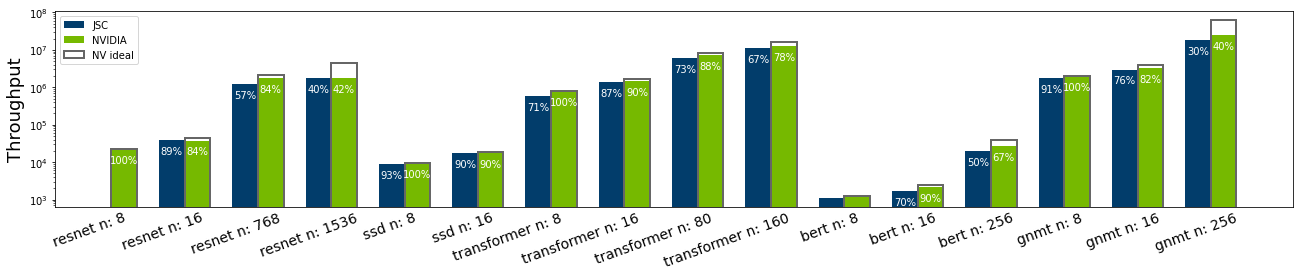

In [13]:
#fig=plt.figure(figsize=(18,4))
x = np.arange(len(output))
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(18,4), facecolor="w")
rects1 = ax.bar(x - width/2, data_jsc, width, label='JSC', color="#023d6b")
rects2 = ax.bar(x + width/2, data_nv, width, label='NVIDIA', color="#76b900")
rects3 = ax.bar(x + width/2, data_nv_ideal, width, label='NV ideal', edgecolor=[0.4,0.4,0.4], lw=2,facecolor=[1,1,1,0])
ax.bar_label(rects1,labels=label_jsc, label_type='center', color="w")
ax.bar_label(rects2,labels=label_nv, label_type='center', color="w")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Throughput', size=18)
ax.semilogy()
plt.xticks(x, rotation=20, size=14)

specific_shift={"resnet": +0.3, "ssd": +0.2, "transformer": +0.6, "bert": +0.2, "gnmt": +0.2}
xtickpositions=[ i-specific_shift[k[1]] for i,k in enumerate(keys_jsc) ]
ax.set_xticks(xtickpositions)
ax.set_xticklabels(labels)
ax.legend()
ax.tick_params(axis="x", length=0)
#plt.margins(tight=True)
plt.subplots_adjust(left=0.04, right=0.995, top=0.9, bottom=0.22)


plt.savefig("benchmark.pdf")

In [14]:
#PIL.Image.open("benchmark.pdf")